In [1]:
import os
import json 
import nibabel as nib
import numpy as np
from matplotlib import pyplot as plt
import random

In [2]:
data_dir = './data/Task01_BrainTumour/'
with open(os.path.join(data_dir, 'dataset.json'), 'r') as f:
    dataset = json.load(f)

In [3]:
train_files = [
    {"image": os.path.join(data_dir, d["image"]), "label": os.path.join(data_dir, d["label"])}
    for d in dataset['training']]


In [4]:
def load_nii(path): 
    return nib.load(path).get_fdata()
     
def normalize_img(img):
    return (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-6)

In [5]:
def load_flair(sample, slice_idx = None):
    return load_nii(sample["image"])[:, :, slice_idx, 0]

def load_mask_brain_edema(sample, slice_idx):
    mask_flair = load_flair(sample, slice_idx)
    mask_labels = load_nii(sample["label"])[:, :, slice_idx]

    # 0: background, 1: brain, 2: edema
    return np.where(
        mask_labels >= 1, 2, np.where(
            mask_flair >= 1, 1, 0
        )
    )

Find slices with more edema area to use in training

In [6]:
def get_edema_pixels(sample):
    mask_labels = load_nii(sample['label'])
    size = mask_labels.shape[0] * mask_labels.shape[1]
    edema_pixels = (mask_labels >= 1).reshape(size, -1).sum(axis=0)

    return edema_pixels

In [7]:
random.randint(0, len(train_files))

126

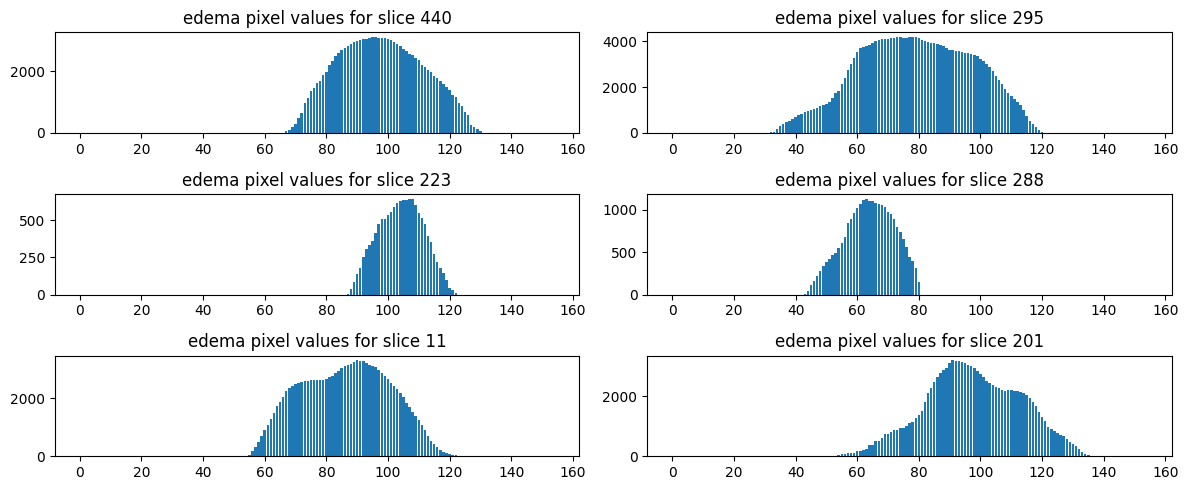

In [8]:
fig, ax = plt.subplots(3, 2, figsize=(12, 5))

for i in range(6):
    idx = random.randint(0, len(train_files))

    pixels = get_edema_pixels(train_files[idx])

    ax[i // 2][i % 2].bar(x=range(len(pixels)), height=pixels)

    ax[i // 2][i % 2].set_title(f'edema pixel values for slice {idx}')

plt.tight_layout()
plt.show()

In [9]:
counts = []

for i in range(len(train_files)):

    edema_pixels = get_edema_pixels(train_files[i])
    counts.append(edema_pixels)

counts = np.array(counts).sum(axis=0)


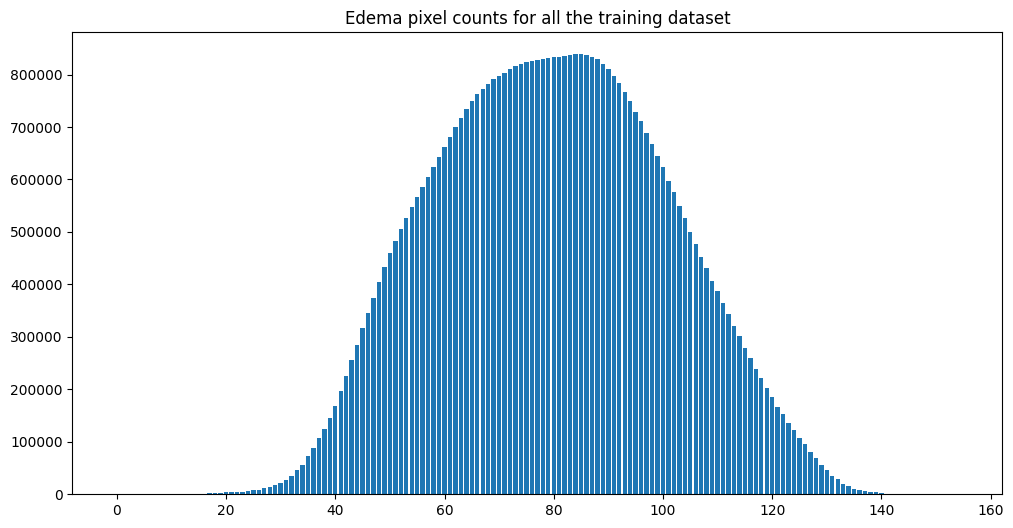

In [10]:
plt.subplots(figsize=(12, 6))
plt.bar(x=range(len(counts)), height=counts)
plt.title('Edema pixel counts for all the training dataset')
plt.show()

In [11]:
counts.mean(), counts.std()

(322561.3870967742, 323851.72160007735)

In [12]:
counts.max()

838562

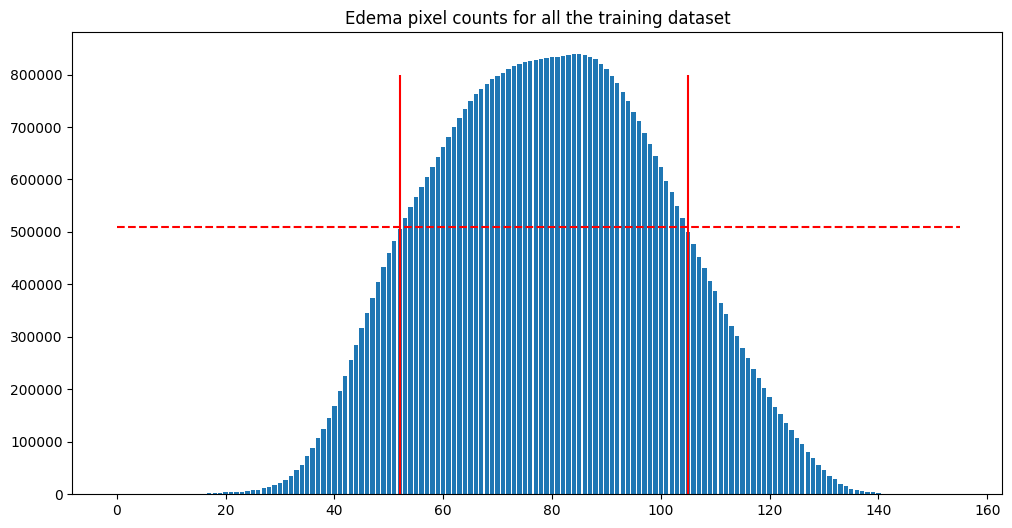

In [13]:
plt.subplots(figsize=(12, 6))
plt.bar(x=range(len(counts)), height=counts)
plt.hlines(83e4 - 32e4, 0, 155, color='red', linestyles='--')
plt.vlines(52, 0, 8e5, color='red')
plt.vlines(105, 0, 8e5, color='red')
plt.title('Edema pixel counts for all the training dataset')
plt.show()

In [14]:
relevant_slices = range(52, 105)

Class weights

In [27]:
def get_brain_pixels(sample):
    mask_labels = load_nii(sample['image'])[:, :, :, 1]
    size = mask_labels.shape[0] * mask_labels.shape[1]
    brain_pixels = (mask_labels >= 1).reshape(size, -1).sum(axis=0)

    return brain_pixels

In [30]:
counts_brain = []

for i in range(len(train_files)):

    edema_pixels = get_brain_pixels(train_files[i])
    counts_brain.append(edema_pixels)

counts_brain = np.array(counts_brain).sum(axis=0)

In [ ]:
counts_brain

array([ 476414,  515412,  555952,  633817,  697455,  808581,  895448,
       1012483, 1104760, 1235834, 1337595, 1476237, 1574077, 1689238,
       1772052, 1876361, 1951003, 2044035, 2110857, 2202754, 2267186,
       2365572, 2436534, 2550637, 2631932, 2767985, 2861286, 3019081,
       3133400, 3325529, 3458727, 3670806, 3809353, 4035186, 4179063,
       4408825, 4554690, 4779578, 4921266, 5137800, 5270971, 5463712,
       5579104, 5737214, 5832873, 5959237, 6039719, 6149796, 6229760,
       6341377, 6429137, 6562004, 6660101, 6807816, 6907019, 7055929,
       7141909, 7286278, 7361788, 7484593, 7546847, 7651806, 7707345,
       7806363, 7860125, 7949225, 7994411, 8073503, 8111882, 8176976,
       8205543, 8252346, 8270706, 8300545, 8309925, 8324864, 8324609,
       8327472, 8319769, 8308735, 8292841, 8271556, 8248367, 8217093,
       8186623, 8144580, 8106315, 8053485, 8006214, 7941244, 7886157,
       7812731, 7748985, 7664420, 7592083, 7498050, 7417834, 7315198,
       7227468, 7115

In [36]:
total_edema = counts[52:105].sum()
total_brain = counts_brain[52:105].sum() - total_edema

In [46]:
weight_brain = (total_brain + total_edema) / total_brain
weight_edema = (total_brain + total_edema) / total_edema

weight_brain, weight_edema

(1.1044463023840125, 10.574297770000033)

In [47]:
# normalize 
weight_brain = weight_brain / (weight_brain + weight_edema)
weight_edema = weight_edema / (weight_brain + weight_edema)

weight_brain, weight_edema

(0.09456892757806241, 0.9911359912670452)